In [1]:
import pandas as pd

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

from string import punctuation

from tqdm import tqdm

SAMPLE = 100_000


[nltk_data] Downloading package stopwords to /home/maxim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/maxim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
from sklearn.pipeline import Pipeline

# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.feature_extraction.text import TfidfVectorizer

# линейный классификатор и классификатор методом ближайших соседей
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

# набор метрик для оценки качества модели
from sklearn import metrics

# модуль поиска по сетке параметров
from sklearn.model_selection import GridSearchCV

In [ ]:
! wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2
! bzip2 -d lenta-ru-news.csv.bz2
! mkdir data
! mv lenta-ru-news.csv data

In [4]:
df_lenta = pd.read_csv('./data/lenta-ru-news.csv', low_memory=False)

In [5]:
df_lenta.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [6]:
df_lenta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800975 entries, 0 to 800974
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     800975 non-null  object
 1   title   800975 non-null  object
 2   text    800970 non-null  object
 3   topic   738973 non-null  object
 4   tags    773756 non-null  object
 5   date    800975 non-null  object
dtypes: object(6)
memory usage: 36.7+ MB


In [7]:
df_lenta['topic'].unique()

array(['Библиотека', 'Россия', 'Мир', 'Экономика', 'Интернет и СМИ',
       'Спорт', 'Культура', 'Из жизни', 'Силовые структуры',
       'Наука и техника', 'Бывший СССР', nan, 'Дом', 'Сочи', 'ЧМ-2014',
       'Путешествия', 'Ценности', 'Легпром', 'Бизнес', 'МедНовости',
       'Оружие', '69-я параллель', 'Культпросвет ', 'Крым'], dtype=object)

# Preprocessing

In [8]:
df_lenta['title'] = df_lenta['title'].astype(str)
df_lenta['topic'] = df_lenta['topic'].astype(str)

In [9]:
df_train = df_lenta.sample(SAMPLE)

In [10]:
# Удаление знаков пунктуации из текста
def remove_punct(text):
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ', 40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    return text.translate(table)

stemmer = SnowballStemmer("russian")

df_train['title_clean'] = df_train['title'].map(lambda x: x.lower())
df_train['title_clean'] = df_train['title_clean'].map(lambda x: remove_punct(x))
df_train['title_clean'] = df_train['title_clean'].map(lambda x: x.split(' '))
df_train['title_clean'] = df_train['title_clean'].map(lambda x: [stemmer.stem(token) for token in x if token not in russian_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])
df_train['title_clean'] = df_train['title_clean'].map(lambda x: ' '.join(x))

# Visualization

<AxesSubplot: >

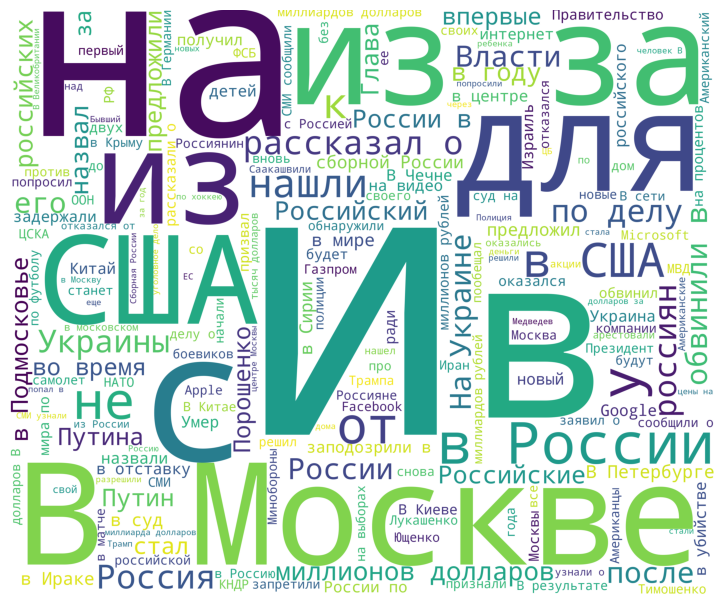

In [11]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

corpus = get_corpus(df_train['title'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

# Train and test

In [12]:
random_state=0

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train['title_clean'], df_train['topic'], test_size=0.1, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

## KNN

In [14]:
knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=5))])

knb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier())])

In [15]:
predicted_sgd = knb_ppl_clf.predict(X_test)

print(metrics.classification_report(predicted_sgd, y_test))

/home/maxim/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/maxim/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

   69-я параллель       0.17      0.21      0.19        24
              nan       0.35      0.26      0.30      1938
       Библиотека       0.67      1.00      0.80         2
           Бизнес       0.11      0.19      0.14        88
      Бывший СССР       0.49      0.45      0.47      1339
              Дом       0.54      0.51      0.52       540
         Из жизни       0.22      0.33      0.27       409
   Интернет и СМИ       0.43      0.55      0.48       786
             Крым       0.07      0.33      0.12         3
    Культпросвет        0.00      0.00      0.00         1
         Культура       0.62      0.71      0.66      1093
          Легпром       0.00      0.00      0.00         0
              Мир       0.63      0.56      0.59      3494
  Наука и техника       0.55      0.62      0.59      1007
      Путешествия       0.26      0.50      0.34        76
           Россия       0.59      0.56      0.58      3

/home/maxim/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## My test

In [16]:
mytest = pd.DataFrame(data=[
    ['Курс доллара вырос на 65 копеек',
     'Россия'],
    ['"Колокола, похищенные из Свято-Троицкого собора в Сан-Франциско, возвращены"',
     'Мир']], 
    columns=['title','topic'] )

mytest['title_clean'] = mytest['title'].map(lambda x: x.lower())
mytest['title_clean'] = mytest['title_clean'].map(lambda x: remove_punct(x))
mytest['title_clean'] = mytest['title_clean'].map(lambda x: x.split(' '))
mytest['title_clean'] = mytest['title_clean'].map(lambda x: [stemmer.stem(token) for token in tqdm(x) if token not in russian_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])
mytest['title_clean'] = mytest['title_clean'].map(lambda x: ' '.join(x))

100%|██████████| 12/12 [00:00<00:00, 20004.63it/s]


In [17]:
mytest.head()

,title,topic,title_clean
0,Курс доллара вырос на 65 копеек,Россия,курс доллар вырос на 65 копеек
1,"""Колокола, похищенные из Свято-Троицкого собор...",Мир,колокол похищен из свят троицк собор в сан фра...


In [18]:
knb_ppl_clf.predict(mytest['title_clean'])

array(['Экономика', 'Мир'], dtype=object)

# Save

In [19]:
import pickle

with open('./models/knb_ppl_clf.pkl', 'wb') as model_knb_ppl_clf:
    pickle.dump(knb_ppl_clf, model_knb_ppl_clf)